In [1]:
import numpy as np
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from core.cluster_validation import morphotopes_to_etcs

In [2]:
regions_datadir = "/data/uscuni-ulce/"
linkage_dir = '/data/uscuni-ulce/processed_data/morphotope_linkage/'

model_params = '_75_0_None_None_False'

In [3]:
linkage_matrix = np.load(f'{linkage_dir}complete_euclidean_full.npy')
regional_clusters = pd.read_parquet(f'{linkage_dir}regional_clusters_2.5.pq').regional_cluster
regional_clusters_data = pd.read_parquet(f'{linkage_dir}regional_clusters_2.5_data.pq')
embedding = pd.read_parquet(f'{linkage_dir}regional_clusters_2.5_embedding.pq')
regional_ward_morphotopes_data = pd.read_parquet(f'{linkage_dir}regional_clusters_2.5_embedding_input.pq')

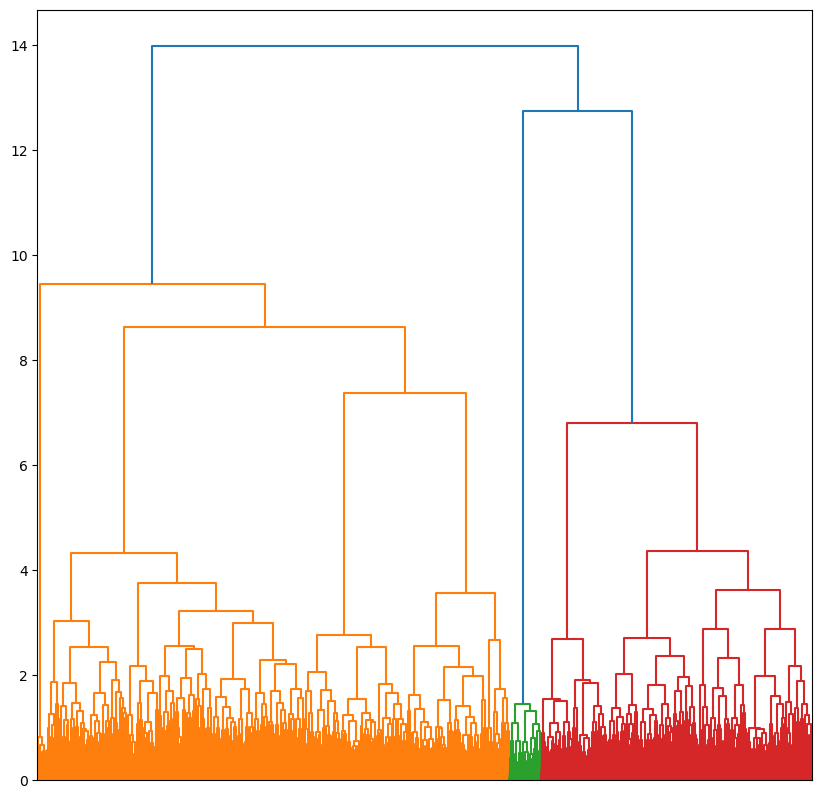

In [4]:
## final dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax, no_labels=True)

In [5]:
final_cutoff = 2.5

In [6]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
# clusters_description = regional_ward_morphotopes_data.groupby(final_clusters).mean()
# clusters_description = grouped_data.groupby(final_clusters).mean()
final_clusters.value_counts()

21    5131
14    4443
9     4314
8     3655
23    3295
4     3291
24    3280
10    3142
11    3061
7     3036
19    3016
17    2713
5     2705
12    2692
18    2646
20    2640
3     2568
13    2304
25    2270
6     1437
16    1407
2     1067
22     965
1      836
15     580
Name: count, dtype: int64

In [7]:
means = regional_clusters_data.groupby(final_clusters).mean()

In [8]:
means.style.background_gradient(axis=0, cmap="BuGn")

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,ldbPWL,ltcBuA,mtbAli,mtbNDi,ltbIBD,stbSAl,sdsLen,sssLin,ldsMSL,ldsRea,ldsAre,sisBpM,sdsSPW,sdsSPO,sdsSWD,mtdDeg,lcdMes,linP3W,linP4W,linPDE,lcnClo,lddNDe,linWID,ldsCDL,xcnSCl,mtdMDi,sddAre,midRea,midAre,sdcLAL,sdcAre,sscCCo,sscERI,mtcWNe,mdcAre,ltcWRB,sicCAR,sdsAre,mibCou,mibAre,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limLPS2
1,108.162103,45.033513,0.906625,0.497916,5.495514,2.522063,0.972625,0.631369,0.411246,1.972787,478.991507,0.370535,2.771229,4.567082,7.393061,4.479823,155.429097,0.988915,136.628476,451.356160,287581.187810,0.225889,16.118079,0.215587,3.849987,3.072667,0.137624,0.726261,0.149017,0.116514,0.000030,0.006549,0.012677,189.509914,0.029789,120.830539,14833.645086,92.562201,46769.421289,26.314043,258.055773,0.465405,0.964304,0.102451,2789.776701,0.000199,0.461400,13426.535683,22.013457,3186.590845,646.701371,0.576113,0.383468,0.300919,113.023236,4.379893,4.379893,116.302789,117.178334,1.000000,1.000000
2,126.260417,48.644759,0.000910,0.517418,5.226101,0.646594,0.980930,0.631985,0.175274,0.001874,119.809078,0.708475,2.821240,13.909438,18.329328,5.475473,229.591498,0.976630,188.836219,314.937441,417734.676076,0.111837,26.476272,0.535228,4.222807,2.962512,0.101194,0.726292,0.109075,0.159188,0.000014,0.004878,0.008722,282.289889,0.001108,176.556929,28687.760433,58.392924,71209.479613,48.080177,774.801274,0.433085,0.964872,0.056354,8227.651557,0.000063,0.188589,29031.059233,2.968604,486.968454,120.541021,0.532021,0.841335,0.377114,41.053580,3.521757,3.521757,134.881727,142.291949,0.999063,0.999063
3,110.265039,45.226862,0.001038,0.527491,4.209015,0.404294,0.997110,0.617754,0.130568,0.043808,104.117824,0.750621,2.911687,15.502486,21.267750,7.731489,661.425496,0.964336,464.043225,437.373637,1057638.630671,0.098535,28.416752,0.739766,4.770015,2.966511,0.079964,0.722062,0.084823,0.187783,0.000007,0.002601,0.004444,760.050732,0.000538,491.929384,110050.932533,86.242114,206384.802158,56.095383,1052.736486,0.439554,0.963720,0.048846,11643.253280,0.000039,0.138625,109162.868419,2.517913,996.539666,111.561554,0.593015,0.897614,0.431024,33.226980,3.371555,3.371555,157.192270,197.669664,1.000000,1.000000
4,67.680474,34.982264,0.000155,0.554691,4.096855,0.425219,0.998451,0.683945,0.134261,0.002127,63.429326,0.758696,3.304453,12.379148,17.012180,8.026680,490.372153,0.953863,403.203088,419.842753,763445.277736,0.137506,25.732056,0.644016,4.982348,2.946673,0.071241,0.711709,0.067101,0.217102,0.000008,0.002686,0.004381,719.588423,0.000187,368.218727,71780.933485,87.316849,147902.829548,43.479460,641.529121,0.437522,0.962735,0.062547,6762.074616,0.000055,0.138885,74299.691022,2.147979,182.114068,62.979057,0.647762,0.913737,0.475484,21.954375,2.708669,2.708669,67.189203,91.577836,0.999088,0.999088
5,55.889757,31.248692,0.000020,0.529287,4.533826,0.315156,0.992861,0.605776,0.412721,0.009612,108.983210,0.571050,1.153237,8.678444,11.772442,6.183256,185.620439,0.943594,137.186946,327.011275,242422.410767,0.258764,24.163405,0.419429,4.108127,2.726340,0.087374,0.696993,0.102617,0.195337,0.000016,0.006916,0.011584,253.206913,0.000596,141.656983,19459.547199,65.118392,40601.877393,30.531739,248.813512,0.353372,0.971093,0.093829,2820.892142,0.000120,0.253617,21171.350915,7.329945,384.008789,109.472641,0.435190,0.859412,0.347453,38.917017,3.260800,3.260800,52.679941,69.898577,0.995933,0.995933
6,75.032521,37.027498,0.000000,0.538781,4.262004,0.846362,0.995520,0.661889,0.215963,0.000696,96.697976,0.650812,3.123423,7.646272,10.899600,6.726672,224.586409,0.970620,262.951654,454.630654,520121.168928,0.212762,21.708189,0.401194,5.236878,2.976862,0.084989,0.721506,0.074375,0.199873,0.000013,0.003465,0.005799,450.075654,0.000052,177.049808,28508.508669,98.496521,83093.551894,30.865693,339.770396,0.458707,0.966793,0.085856,3264.356432,0.000106,0.250661,27932.691180,3.371955,312.384264,97.828937,0.625712,0.789780,0.411718,31.208546,2.995022,2.995022,65.69

### Plotting

In [9]:
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [255,255,255]

In [10]:
region_id = 69333 

# region_id = 99886 # bratislava

# region_id = 151676 # vilnius

# region_id = 8707 # mainz/frankfurt
# region_id = 5883 #  freiburg
# region_id = 38679 #munich
# region_id = 55763 # berlin

# region_id = 86873 # vienna

# region_id = 107131 # krakow


# region_id= 66593

In [11]:
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)

In [12]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")

In [13]:
etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [14]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 1.05 s, sys: 112 ms, total: 1.16 s
Wall time: 1.16 s


In [15]:
from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters - {final_cutoff}')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)
    

In [16]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.final].values.astype('uint8')

### Interactive dendro

In [36]:
from core import interactive_dendrogram
import jscatter

scatter_df = interactive_dendrogram.get_dendrogram_scatter_data(linkage_matrix)

def get_subcluster_children(focus):
    child, parent = linkage_matrix[focus - n, 0].astype(int), linkage_matrix[focus - n, 1].astype(int)
    children_ids = interactive_dendrogram.get_children(linkage_matrix, child, parent)
    children_morphotopes = regional_ward_morphotopes_data.iloc[children_ids].index
    return children_morphotopes

In [37]:
scatter = jscatter.Scatter(data=scatter_df, x='x', y='y', height=640, width=1280)
scatter.axes(grid=True)
scatter.connect(by='group1', order='order1')
scatter.options({ 'pointConnectionTolerance': 1 })

In [38]:
scatter.show()

In [61]:
selected_node = scatter.selection()[0]

n = linkage_matrix.shape[0] + 1

left = scatter_df.loc[selected_node, 'child'].astype(int)
right = scatter_df.loc[selected_node, 'parent'].astype(int)

left_children = get_subcluster_children(left)
right_children = get_subcluster_children(right)

cluster_colors = np.full((etcs.shape[0], 3), 0) # everything black
cluster_colors[etcs.regional.isin(left_children)] = [141,211,199] # left blue - 1
cluster_colors[etcs.regional.isin(right_children)] = [255,255,179] # right yellow - 2
layer.get_fill_color = cluster_colors.astype('uint8')

In [54]:
left_data = regional_ward_morphotopes_data.loc[left_children].mean()
right_data = regional_ward_morphotopes_data.loc[right_children].mean()
# assert np.isclose(pd.DataFrame({1:left_data, 2: right_data}).T.values, clusters_description.values).all()

diffs = (left_data - right_data)
diffs = diffs[(diffs ** 2).sort_values(ascending=False).index].head(20)
diffs

xcnSCl    0.769000
linP3W   -0.346809
mtbAli   -0.278451
stbSAl   -0.246251
linP4W    0.223298
lcnClo   -0.206647
sssLin    0.193794
sscERI    0.191144
mtdDeg    0.153110
sscCCo    0.151981
sdcAre    0.145620
sdsSWD   -0.144873
sisBpM   -0.142969
mdcAre    0.139577
mtcWNe   -0.131607
lcdMes    0.130461
sdcLAL    0.122370
midAre    0.121186
sdsSPW    0.110144
ldsAre    0.110026
dtype: float64